# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [692]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [693]:
with open(r"/home/an/Downloads/anek.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [694]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [695]:
cut_text = cut_data(text)

In [696]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [697]:
unique_chars = tuple(set(text))
print(unique_chars)
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

('理', '−', '最', '成', '然', 'Ц', 'ö', 'H', '̈', '举', '²', 'c', 'б', '̆', 'Z', '<', 'Е', '☺', 'Ч', 'й', '7', 'с', '*', '4', '虽', '°', 'V', 'т', 'д', '-', '%', '5', 'х', '_', '#', '’', 'ë', 'e', 'ъ', 'О', '$', 'Н', 'И', 'к', ';', 'Д', '\u200b', 'н', 'ц', 's', '人', 'k', '应', 'в', 'I', 'b', '由', 'э', 'F', 'Ё', 'п', 'и', 'В', 'Г', 'ю', '0', 'Ы', ',', '@', '，', 'M', 'Ь', '+', 'Ш', 'Ж', 'j', '»', 'ч', 'У', '☻', '"', 'А', 'w', 'v', 'Q', 'O', 'f', 'з', 'я', 'ж', 'W', '́', '▒', '“', 'ы', '为', 'K', 'J', '?', 'ь', '.', '直', 'а', 'ф', 'S', 'П', '”', 'Y', 'U', '1', '6', 'o', 'P', 'L', 'г', '接', 'x', '/', '&', 'a', '老', '!', 'р', '新', '9', '×', 'X', 'ё', '副', 'G', 'Я', '№', 'y', '|', '事', '表', '>', 'p', '`', '代', 'E', '″', 'm', ' ', 'С', 'h', '给', '会', 'Х', 'D', '结', 'π', 'Р', '=', 'B', 'q', '。', '\n', 'u', '¿', 'о', 'Т', 'r', '果', 'Ъ', 'C', 'щ', 't', 'Э', 'z', 'Ø', 'Ю', 'ο', ':', '的', 'Щ', 'n', 'd', '8', '2', 'N', 'л', 'ш', 'Ф', '已', '3', 'l', '长', '名', 'R', '命', '€', 'i', 'g', '任', 'Й', '\ufeff', 'З'

Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [698]:
def encode(sentence, vocab):
    l = []
    for ch in sentence:
        l.append(vocab[ch])
    return l

def decode(tokens, vocab):
    l = ""
    for tok in tokens:
        l += vocab[tok]
    return l

a = encode("sdfsdf asdfasdasdkslf sdfkh asdf", char2int)
print(a)
b = decode(a, int2char)
print(b)

[49, 177, 86, 49, 177, 86, 143, 119, 49, 177, 86, 119, 49, 177, 119, 49, 177, 51, 49, 186, 86, 143, 49, 177, 86, 51, 145, 143, 119, 49, 177, 86]
sdfsdf asdfasdasdkslf sdfkh asdf


Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [699]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    batch_size, seq_len = int_words.shape
    words_one_hot = torch.zeros((batch_size, seq_len, vocab_size))
    
    for batch_idx in range(batch_size):
        words_one_hot[batch_idx, torch.arange(seq_len), int_words[batch_idx]] = 1.0
    return words_one_hot

Проверьте ваш код.

In [700]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [701]:
class Tokenizer:
    def __init__(self, text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ["<pad>", "<bos>", "<eos>"]
        self.unique_chars = list(set(text))
        self._add_special("<pad>")
        self._add_special("<bos>")
        self._add_special("<eos>")
        
        self.int2char = dict(enumerate(self.unique_chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
    
    def _add_special(self, symbol) -> None:
        if symbol not in self.unique_chars:
            self.unique_chars.append(symbol)

    @property
    def vocab_size(self):
        return len(self.unique_chars)
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars]

    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx]

    def encode(self, chars):
        chars = ["<bos>"] + list(chars) + ["<eos>"]
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join([ch for ch in chars if ch not in ["<bos>", "<eos>"]])


In [702]:
import torch
from torch.utils.data import Dataset

class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        joke = self.cut_text[item]
        encoded_joke = self.tokenizer.encode(joke)

        if len(encoded_joke) > self.max_len:
            encoded_joke = encoded_joke[:self.max_len]

        padding_num = self.max_len - len(encoded_joke)
        padded_joke = encoded_joke + [self.pad_index] * padding_num

        return torch.tensor(padded_joke), len(encoded_joke)


In [703]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [704]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        vocab_size = self.tokenizer.vocab_size
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=self.n_hidden, num_layers=self.n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(self.n_hidden, vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.shape
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)

        one_hot = one_hot_encode(x, self.tokenizer.vocab_size)

        packed_embeds = pack_padded_sequence(one_hot, lengths, batch_first=True, enforce_sorted=False).to(device)
        packed_output, hidden = self.rnn(packed_embeds, h0)
        out, lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len)
        out = self.dropout(out)
        logits = self.fc(out)

        return logits, hidden

    # def inference(self, prefix='<bos>'):
    #     tokens = torch.tensor(self.tokenizer.encode(prefix)).unsqueeze(0).to(device)

    #     while tokens.shape[1] < self.max_len:
    #         lengths = torch.tensor([tokens.shape[1]], dtype=torch.int64)  
    #         logits, hidden = self.forward(tokens, lengths)
    #         logits = logits[:, -1, :]

    #         new_token = torch.argmax(logits, dim=-1).unsqueeze(0)
    #         tokens = torch.cat([tokens, new_token], dim=1)

    #         if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
    #             break

    #     return self.tokenizer.decode(tokens.squeeze().cpu().numpy())
    

    def inference(self, prefix='<bos>'):
        tokens = torch.tensor(self.tokenizer.encode(prefix)).unsqueeze(0).to(device)

        while tokens.shape[1] < self.max_len:
            lengths = torch.tensor([tokens.shape[1]], dtype=torch.int64)  
            logits, hidden = self.forward(tokens, lengths)
            logits = logits[:, -1, :]

            new_token = torch.argmax(logits, dim=-1).unsqueeze(0)
            tokens = torch.cat([tokens, new_token], dim=1)

            if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                break

        return self.tokenizer.decode(tokens.squeeze().cpu().numpy())


Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [705]:
batch_size = 4
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [706]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad()

    input_data, target_lengths = train_batch

    input_data = input_data.to(device)

    logits, _ = model(input_data, target_lengths)

    logits = logits.view(-1, vocab_size)

    target_data = input_data.view(-1)

    mask = target_data != tokenizer.encode_symbol("<pad>")
    logits = logits[mask]
    target_data = target_data[mask]

    loss = criterion(logits, target_data)

    loss.backward()
    optimizer.step()

    return loss

Инициализируйте модель, функцию потерь и оптимизатор.

In [707]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [ ]:
model.eval()  

prefix = "rtfdg"
# prefix = "<bos>"
# prefix = "<eos>" 
generated_text = model.inference(prefix)
print("Output:", generated_text)

Output: <bos>的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的


In [709]:
def plot_losses(losses):
    clear_output()
    
    losses_cpu = [loss.cpu().item() for loss in losses] 
    
    plt.plot(range(1, len(losses_cpu) + 1), losses_cpu)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

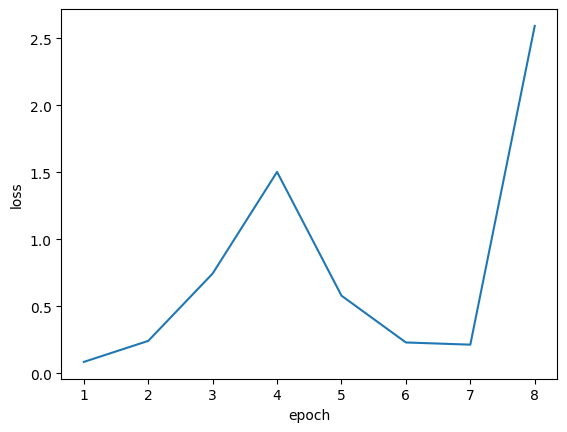

In [710]:
losses = []
num_epochs = 8

for epoch in range(1, num_epochs + 1):
    model.train()  
    epoch_loss = 0
        
    for batch_idx, train_batch in enumerate(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)  
    
    plot_losses(losses)

In [711]:
[model.inference("") for _ in range(10)]

['-                          тооо                                                                т       ооооотоототооооооо                                              оноооотоооооооооооооо                                                          ттоооооооотоо                                                                                                    тноооооотооооооооонтоооооооо                                             ттоооооотоооооооооооооооооооотоо             тоотооооооооотоооооо             ',
 '-          тооооооооооооо                                       ттоооокоооотоооооооотоооо                                                                    оноооооооо                     коооооооооооооооо         тоооо                отоооооооооооооооооооооооооооооооооооооооооотоооо                                                                                                                                                                         ттооооооот                    

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [712]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc